In [1]:
from graphdatascience import GraphDataScience
import pandas as pd
import umap
import plotly.express as px
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import math
from getpass import getpass

Spin up your own sandbox using the Twitch dataset at https://sandbox.neo4j.com

Replace the URL below with the URL from your sandbox.

In [64]:
bolt_url = "bolt://3.95.218.232:7687"

In [65]:
gds = GraphDataScience(bolt_url, auth=("neo4j", getpass("Neo4j password")))

# Impute median values for streams where the sandbox data has null

In [4]:
gds.run_cypher("""
MATCH (s:Stream) WHERE s.createdAt IS NOT NULL
SET s.accountAge = duration.inDays(s.createdAt, date('2021-05-10')).days
""")

Empty DataFrame
Columns: []
Index: []

In [5]:
gds.run_cypher("""
MATCH (s:Stream) WHERE s.accountAge IS NOT NULL
WITH percentileCont(s.accountAge, 0.5) AS medianAge
MATCH (s:Stream) WHERE s.accountAge IS NULL
SET s.accountAge = toInteger(medianAge)
""")

Empty DataFrame
Columns: []
Index: []

In [6]:
gds.run_cypher("""
MATCH (s:Stream) WHERE s.total_view_count IS NOT NULL
WITH percentileCont(s.total_view_count, 0.5) AS medianViews
MATCH (s:Stream) WHERE s.total_view_count IS NULL
SET s.total_view_count = toInteger(medianViews)
""")

Empty DataFrame
Columns: []
Index: []

# Create graph projection

In [7]:
g_chatter, result = gds.graph.project("chatter", 
                                      {"Stream": {"properties":["accountAge", "total_view_count", "followers"]}, 
                                       "User": {}}, 
                                     {"CHATTER":{"orientation":"UNDIRECTED"}})

Loading:   0%|          | 0/100 [00:00<?, ?%/s]

In [8]:
result

nodeProjection            {'User': {'label': 'User', 'properties': {}}, ...
relationshipProjection    {'CHATTER': {'aggregation': 'DEFAULT', 'orient...
graphName                                                           chatter
nodeCount                                                           4678779
relationshipCount                                                  20036562
projectMillis                                                         10276
Name: 0, dtype: object

# Drop nodes outside the giant component
That saves resources on a Sandbox instance. Disconnected User nodes won't influence FastRP for the Stream nodes we care about.

In [9]:
gds.wcc.mutate(g_chatter, mutateProperty='wccId')

WCC:   0%|          | 0/100 [00:00<?, ?%/s]

mutateMillis                                                             1
nodePropertiesWritten                                              4678779
componentCount                                                      985301
componentDistribution    {'min': 1, 'p5': 1, 'max': 3693487, 'p999': 1,...
postProcessingMillis                                                   531
preProcessingMillis                                                      5
computeMillis                                                          590
configuration            {'mutateProperty': 'wccId', 'jobId': '84b18db2...
Name: 0, dtype: object

In [10]:
gds.run_cypher("""
CALL gds.graph.nodeProperty.stream("chatter", "wccId") 
YIELD propertyValue 
WITH propertyValue, count(*) AS nodeCount 
RETURN propertyValue, nodeCount
ORDER BY nodeCount DESC
LIMIT 1
               """ )

propertyValue  nodeCount
0              0    3693479

In [11]:
g_filtered_chatter, result = gds.graph.filter("filtered_chatter", g_chatter, "n.wccId = 0", "*")

In [12]:
gds.graph.drop(g_chatter)

graphName                                                          chatter
database                                                             neo4j
databaseLocation                                                     local
memoryUsage                                                               
sizeInBytes                                                             -1
nodeCount                                                          4678779
relationshipCount                                                 20036562
configuration            {'relationshipProjection': {'CHATTER': {'aggre...
density                                                           0.000001
creationTime                           2024-09-30T18:52:38.744631824+00:00
modificationTime                       2024-09-30T18:52:49.895307826+00:00
schema                   {'graphProperties': {}, 'nodes': {'User': {'wc...
schemaWithOrientation    {'graphProperties': {}, 'nodes': {'User': {'wc...
Name: 0, dtype: object

# Find Stream nodes that chatter with the same neighbor nodes

In [13]:
gds.nodeSimilarity.filtered.mutate(g_filtered_chatter,
                                  topK=4,
                                  sourceNodeFilter="Stream",
                                  targetNodeFilter="Stream",
                                  mutateRelationshipType="HAS_SIMILAR_INTERACTORS",
                                  mutateProperty="similarity",
                                  similarityCutoff=0.03)

preProcessingMillis                                                       0
computeMillis                                                         63744
mutateMillis                                                            451
postProcessingMillis                                                      0
nodesCompared                                                          4538
relationshipsWritten                                                  16696
similarityDistribution    {'min': 0.029999971389770508, 'p5': 0.03439795...
configuration             {'mutateProperty': 'similarity', 'jobId': '020...
Name: 0, dtype: object

Create a new graph that has just the HAS_SIMILAR_INTERACTIONS relationships between Stream nodes. That way we can drop the parent graph to free up resources.

In [14]:
g_stream, result = gds.graph.filter("streams", g_filtered_chatter,
                 "n:Stream", 
                 "r:HAS_SIMILAR_INTERACTORS")

In [15]:
gds.graph.drop(g_filtered_chatter)

graphName                                                 filtered_chatter
database                                                             neo4j
databaseLocation                                                     local
memoryUsage                                                               
sizeInBytes                                                             -1
nodeCount                                                          3693479
relationshipCount                                                 20053258
configuration            {'relationshipProperties': {}, 'jobId': '18f6b...
density                                                           0.000001
creationTime                           2024-09-30T18:52:54.511476469+00:00
modificationTime                       2024-09-30T18:54:04.715910615+00:00
schema                   {'graphProperties': {}, 'nodes': {'User': {'wc...
schemaWithOrientation    {'graphProperties': {}, 'nodes': {'User': {'wc...
Name: 0, dtype: object

# Check out weakly connected components on the new graph

In [16]:
gds.graph.relationshipProperties.write(g_stream, "HAS_SIMILAR_INTERACTORS", ["similarity"])

writeMillis                                                             860
graphName                                                           streams
relationshipType                                    HAS_SIMILAR_INTERACTORS
relationshipProperties                                         [similarity]
relationshipsWritten                                                  16696
propertiesWritten                                                     16696
configuration             {'jobId': '63287895-7360-44b8-8ed8-90669cbfe4f...
Name: 0, dtype: object

In [17]:
gds.wcc.stats(g_stream)['componentDistribution']

{'min': 1,
 'p5': 1,
 'max': 4360,
 'p999': 4360,
 'p99': 10,
 'p1': 1,
 'p10': 1,
 'p90': 2,
 'p50': 1,
 'p25': 1,
 'p75': 1,
 'p95': 4,
 'mean': 34.1203007518797}

In [18]:
gds.wcc.mutate(g_stream, mutateProperty="streamWccId")

mutateMillis                                                             0
nodePropertiesWritten                                                 4538
componentCount                                                         133
componentDistribution    {'min': 1, 'p5': 1, 'max': 4360, 'p999': 4360,...
postProcessingMillis                                                     1
preProcessingMillis                                                      0
computeMillis                                                            9
configuration            {'mutateProperty': 'streamWccId', 'jobId': '61...
Name: 0, dtype: object

In [19]:
gds.graph.nodeProperties.stream(g_stream, "streamWccId")['propertyValue'].value_counts()

propertyValue
0       4360
354       10
14         8
312        7
1049       6
        ... 
4262       1
4269       1
4275       1
4280       1
58         1
Name: count, Length: 133, dtype: int64

# Use Louvain to get a sense of graph structure

In [20]:
louvain_result = gds.louvain.mutate(g_stream, mutateProperty="louvainId", relationshipWeightProperty="similarity")
louvain_result['communityCount']

Louvain:   0%|          | 0/100 [00:00<?, ?%/s]

285

In [21]:
louvain_result['communityDistribution']

{'min': 1,
 'p5': 1,
 'max': 1358,
 'p999': 1358,
 'p99': 237,
 'p1': 1,
 'p10': 1,
 'p90': 24,
 'p50': 4,
 'p25': 1,
 'p75': 10,
 'p95': 38,
 'mean': 15.92280701754386}

In [22]:
louvain_result['communityCount']

285

# Run fastRP with no node properties

In [23]:
gds.fastRP.mutate(g_stream, embeddingDimension=128, iterationWeights=[ 0, 1, 1, 0.5, 0.5], 
                  mutateProperty="embedding1",
                  relationshipWeightProperty="similarity",
                  randomSeed=25)

nodePropertiesWritten                                                 4538
mutateMillis                                                             0
nodeCount                                                             4538
preProcessingMillis                                                      0
computeMillis                                                          195
configuration            {'randomSeed': 25, 'mutateProperty': 'embeddin...
Name: 0, dtype: object

# Use kmeans to identify 6 communities based on the embedding

In [24]:
gds.kmeans.mutate(g_stream, nodeProperty="embedding1", k=6, mutateProperty="kmeans1")

mutateMillis                                                                 0
nodePropertiesWritten                                                     4538
communityDistribution        {'min': 45, 'p5': 45, 'max': 1735, 'p999': 173...
centroids                    [[0.008986694738268852, 0.009373119100928307, ...
averageDistanceToCentroid                                             1.622185
averageSilhouette                                                          0.0
postProcessingMillis                                                         1
preProcessingMillis                                                          0
computeMillis                                                              247
configuration                {'mutateProperty': 'kmeans1', 'jobId': 'befa0f...
Name: 0, dtype: object

# Analyze results of FastRP

In [25]:
property_df = gds.graph.nodeProperties.stream(g_stream, ['louvainId', 'embedding1', 'kmeans1'], ["Stream"], separate_property_columns=True)

## Check to see if different values in the embedding vector have a strong positive or negative correlation
We expect to see the bright red diagonal because each value is correlated with itself. We don't expect a lot of other bright red spots or deep blue spots.

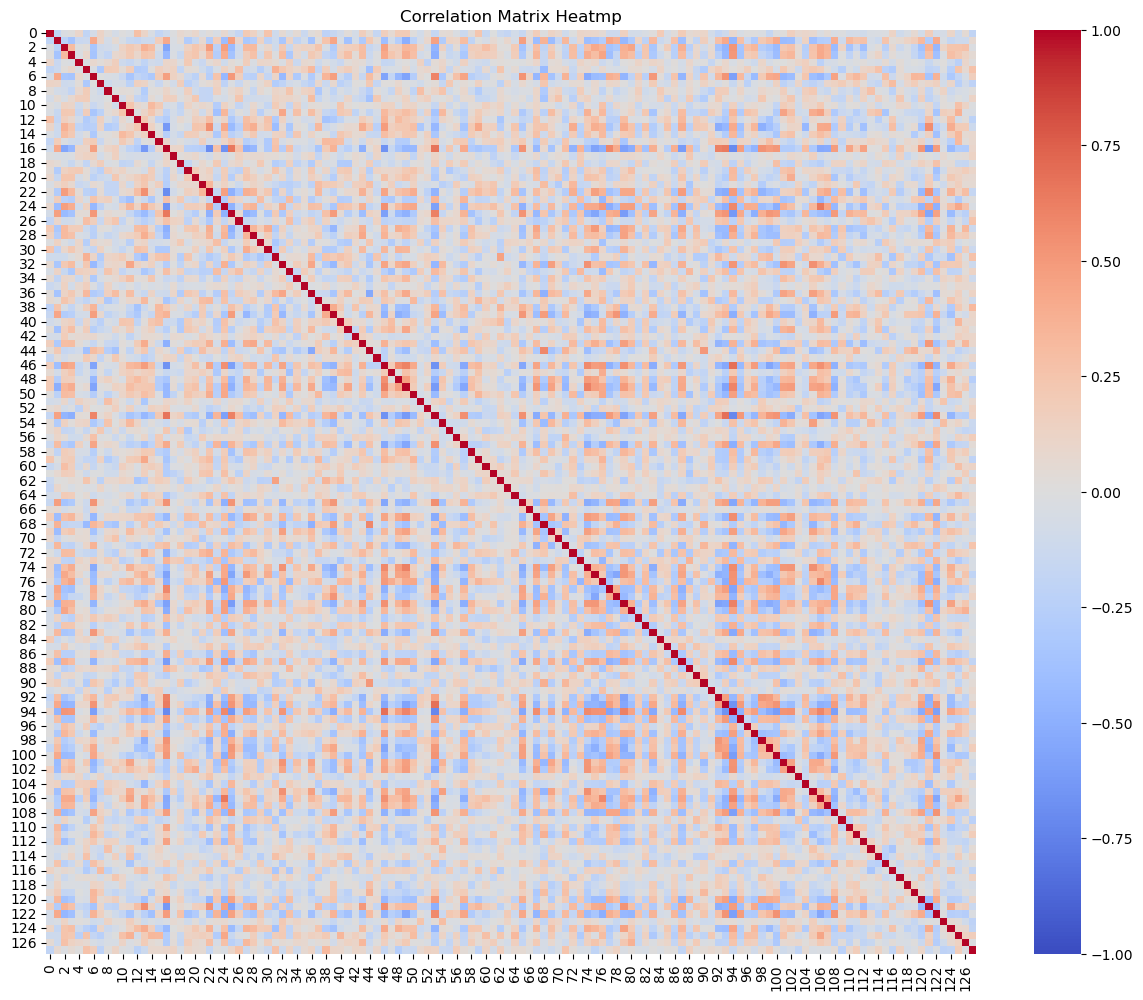

In [26]:
embedding_array = np.array(property_df['embedding1'].tolist())
correlation_matrix = np.corrcoef(embedding_array, rowvar=False)
plt.figure(figsize=(15,12))
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm', vmin=-1.0, vmax=1.0)
plt.title('Correlation Matrix Heatmp')
plt.show()

## Visualize the data as a 3d scatter plot

In [27]:
reducer = umap.UMAP(n_components=3)
embedding_reduced = reducer.fit_transform(np.array(list(property_df['embedding1'])))

In [28]:
df_reduced = pd.DataFrame(embedding_reduced, columns=['umap1', 'umap2', 'umap3'])
df_reduced = pd.concat([property_df.drop("embedding1", axis=1).reset_index(drop=True), df_reduced], axis=1)

Associate each stream node with a Game. We don't know how much time the spend playing each game, so rank the games in descending order by the number of Streams associated with the Game. Pick the most popular played Game for each Stream. If the Stream doesn't play a game in the top 20 most popular Games, return "Other".

In [29]:
game_df = gds.run_cypher("""
MATCH (g:Game)
WHERE g.name <> ""
WITH g, COUNT{(:Stream)-[:PLAYS]->(g)} AS streams
ORDER BY streams DESC
WITH collect(g) AS games
MATCH (s:Stream)
WITH s, games, COLLECT {MATCH (s)-[:PLAYS]->(g) RETURN g} AS playedGames
RETURN id(s) AS nodeId, 
COALESCE(REDUCE(game=null, g in games[..20] | CASE WHEN game IS NOT NULL THEN game WHEN g in playedGames THEN g.name END), "Other") AS mostPopularPlayedGame
                         """)

In [30]:
df_reduced = df_reduced.merge(game_df, on='nodeId', how="left")

In [31]:
fig = px.scatter_3d(df_reduced, x='umap1', y='umap2', z='umap3', color='louvainId', width=900, height=900)
fig.update_layout(
    yaxis={"scaleanchor":"x", "scaleratio":1}
)
fig.show()

In [32]:
fig = px.scatter_3d(df_reduced, x='umap1', y='umap2', z='umap3', color='kmeans1', width=900, height=900)
fig.update_layout(
    yaxis={"scaleanchor":"x", "scaleratio":1}
)
fig.show()

In [33]:
fig = px.scatter_3d(df_reduced, x='umap1', y='umap2', z='umap3', color='mostPopularPlayedGame', width=900, height=900)
fig.update_layout(
    yaxis={"scaleanchor":"x", "scaleratio":1}
)
fig.show()

# Examine Stream properties

In [34]:
feature_df = gds.graph.nodeProperties.stream(g_stream, ['accountAge', 'total_view_count', 'followers'], separate_property_columns=True)

In [35]:
feature_df.shape

(4538, 4)

array([[<Axes: title={'center': 'accountAge'}>,
        <Axes: title={'center': 'total_view_count'}>],
       [<Axes: title={'center': 'followers'}>, <Axes: >]], dtype=object)

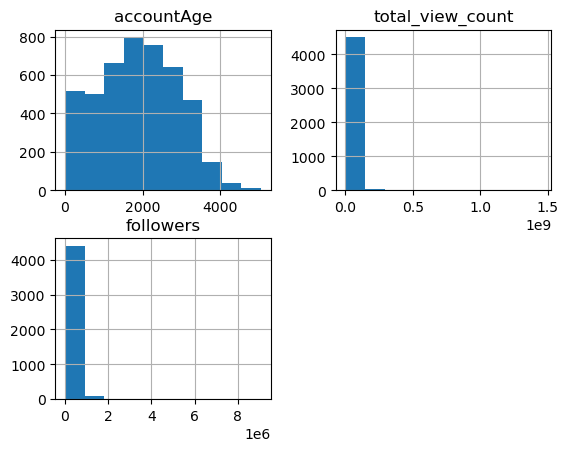

In [36]:
feature_df[['accountAge', 'total_view_count', 'followers']].hist()

It looks like a log transformation would give us better distribution for total_view_count and followers.

In [37]:
feature_df['logTotalViewCount'] = feature_df['total_view_count'].map(lambda x: math.log(x+1))
feature_df['logFollowers'] = feature_df['followers'].map(lambda x: math.log(x+1))

array([[<Axes: title={'center': 'accountAge'}>,
        <Axes: title={'center': 'logTotalViewCount'}>],
       [<Axes: title={'center': 'logFollowers'}>, <Axes: >]], dtype=object)

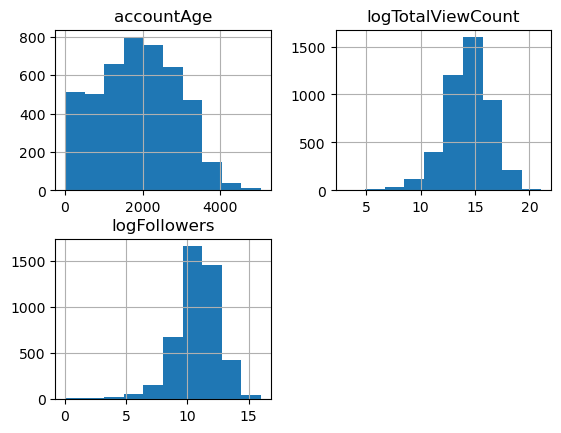

In [38]:
feature_df[['accountAge', 'logTotalViewCount', 'logFollowers']].hist()

# Scale node properties

In [39]:
gds.scaleProperties.mutate(g_stream,
                           nodeLabels=["Stream"],
                           mutateProperty="logFollowers",
                           nodeProperties=["followers"],
                           scaler={"type": "Log", "offset":1})
gds.scaleProperties.mutate(g_stream,
                           nodeLabels=["Stream"],
                           mutateProperty="logTotalViewCount",
                           nodeProperties=["total_view_count"],
                           scaler="Log")

scalerStatistics                                  {'total_view_count': {}}
nodePropertiesWritten                                                 4538
mutateMillis                                                             0
postProcessingMillis                                                     0
preProcessingMillis                                                      0
computeMillis                                                            8
configuration            {'mutateProperty': 'logTotalViewCount', 'nodeP...
Name: 0, dtype: object

In [40]:
scale_results = gds.scaleProperties.mutate(g_stream,
                           nodeLabels=["Stream"],
                           mutateProperty="scaledProperties",
                           nodeProperties=["logFollowers", "logTotalViewCount", "accountAge"],
                           scaler="MinMax"
                           )
scale_results['scalerStatistics']

{'accountAge': {'min': [0.0], 'max': [5051.0]},
 'logTotalViewCount': {'min': [3.044522437723423],
  'max': [21.095854561507537]},
 'logFollowers': {'min': [0.0], 'max': [16.02083138316706]}}

# Run fastRP with node properties

In [41]:
gds.fastRP.mutate(g_stream, embeddingDimension=128, iterationWeights=[0, 1, 1, 0.5, 0.5], mutateProperty="embedding2",
                  featureProperties=["scaledProperties"],
                  nodeLabels=["Stream"], 
                  nodeSelfInfluence=0.15,
                  propertyRatio=0.125,
                  relationshipWeightProperty="similarity",
                  randomSeed=25
                  )

nodePropertiesWritten                                                 4538
mutateMillis                                                             0
nodeCount                                                             4538
preProcessingMillis                                                      0
computeMillis                                                          379
configuration            {'randomSeed': 25, 'mutateProperty': 'embeddin...
Name: 0, dtype: object

# Create kmeans clusters on new embedding

In [42]:
gds.kmeans.mutate(g_stream, k=6, nodeProperty="embedding2", mutateProperty="knn2")

mutateMillis                                                                 0
nodePropertiesWritten                                                     4538
communityDistribution        {'min': 117, 'p5': 117, 'max': 1583, 'p999': 1...
centroids                    [[0.00613938644528389, 0.00019454640278127044,...
averageDistanceToCentroid                                             0.791517
averageSilhouette                                                          0.0
postProcessingMillis                                                         1
preProcessingMillis                                                          0
computeMillis                                                              135
configuration                {'mutateProperty': 'knn2', 'jobId': '809adc16-...
Name: 0, dtype: object

# Analyze results of FastRP with properties included

In [43]:
property_df = gds.graph.nodeProperties.stream(g_stream, ['embedding2', 'knn2', 'louvainId', 'accountAge', 'logFollowers', 'logTotalViewCount'], separate_property_columns=True)

The warnings and white stripes below are because we ended up with columns with all zeros. We're willing to accept that because it decreases the chance of not using a feature all together.

/Users/nathansmith/anaconda3/envs/neo4j/lib/python3.11/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning:

invalid value encountered in divide

/Users/nathansmith/anaconda3/envs/neo4j/lib/python3.11/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning:

invalid value encountered in divide



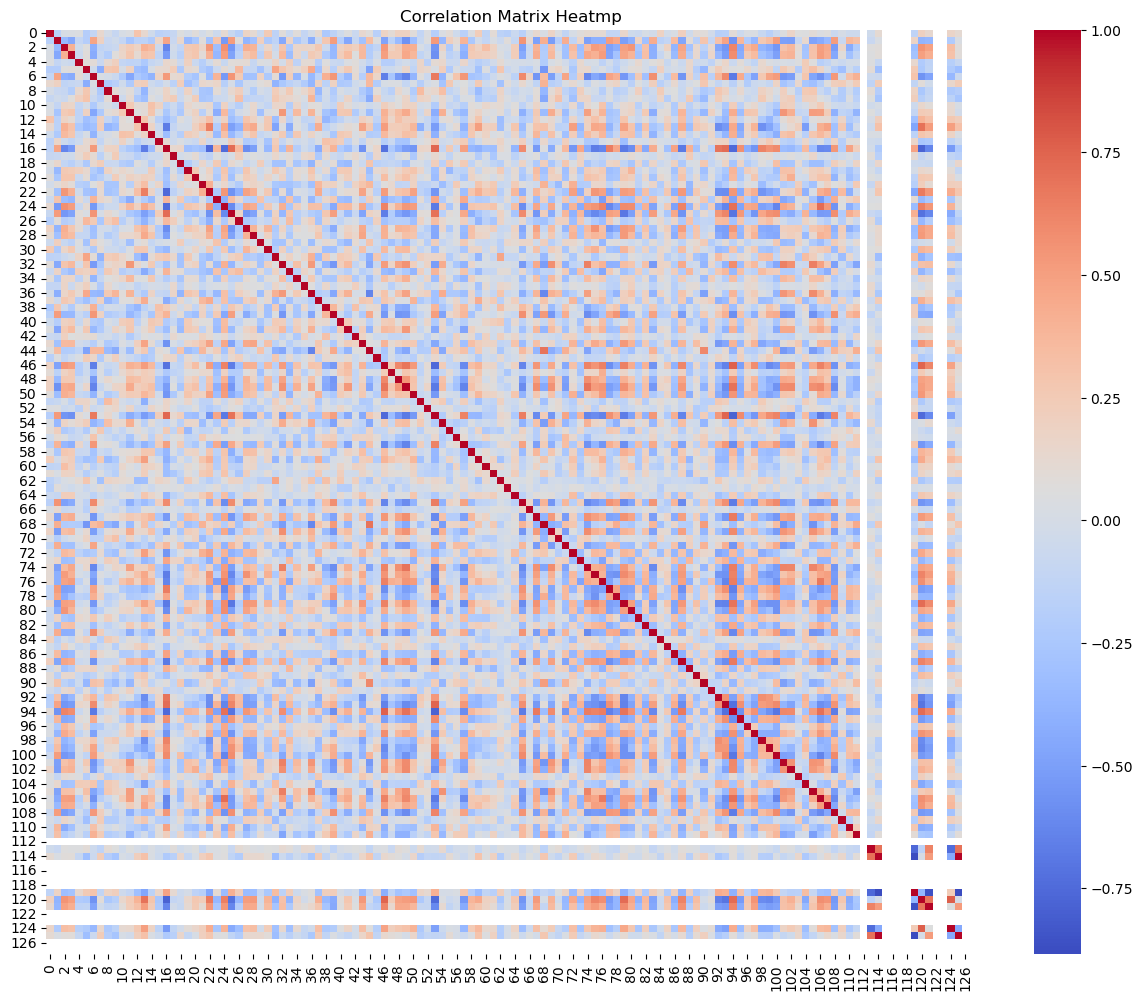

In [44]:
embedding_array = np.array(property_df['embedding2'].tolist())
correlation_matrix = np.corrcoef(embedding_array, rowvar=False)
plt.figure(figsize=(15,12))
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm')
plt.title('Correlation Matrix Heatmp')
plt.show()

In [45]:
# Assuming embedding_array is your 2D numpy array
variances = np.var(embedding_array, axis=0)

# Print variances
print(variances)

# Identify columns with zero or very small variance
zero_var_columns = np.where(variances < 1e-10)[0]
print("Columns with zero or very small variance:", zero_var_columns)

[0.0069477  0.01051497 0.0108268  0.00921442 0.00720871 0.01292313
 0.01507278 0.00740354 0.00857302 0.00689347 0.00588584 0.0126806
 0.00755825 0.0190759  0.00997848 0.0077831  0.04113415 0.00707582
 0.00796897 0.00933449 0.00668387 0.00905187 0.0165208  0.00868277
 0.02237515 0.0160999  0.00895402 0.01245744 0.0077775  0.00814604
 0.00812672 0.01094314 0.01302516 0.00811015 0.0075449  0.00669066
 0.01359618 0.00774448 0.01016539 0.0146795  0.00942682 0.01121796
 0.00743576 0.01089881 0.01673794 0.00641665 0.02003056 0.00923108
 0.01200124 0.0232049  0.01021109 0.00770784 0.00712675 0.02114887
 0.01199882 0.0085694  0.00721452 0.01234814 0.00742977 0.00987487
 0.00561172 0.00759045 0.0085695  0.00576615 0.00606033 0.01721933
 0.00616055 0.01805837 0.01930905 0.0104586  0.00599342 0.01428908
 0.0102787  0.00835262 0.01636818 0.01189574 0.01639659 0.01064383
 0.01125036 0.02290546 0.01308688 0.00657045 0.00768776 0.01269401
 0.00755807 0.00712923 0.00754623 0.01328305 0.0111224  0.00638

In [46]:
embedding_reduced = reducer.fit_transform(np.array(list(property_df['embedding2'])))

In [47]:
df_reduced = pd.DataFrame(embedding_reduced, columns=['umap1', 'umap2', 'umap3'])
df_reduced = pd.concat([property_df.drop("embedding2", axis=1).reset_index(drop=True), df_reduced], axis=1)

In [48]:
df_reduced['logTotalViewCount'] = df_reduced['logTotalViewCount'].map(lambda x: x[0])
df_reduced['logFollowers'] = df_reduced['logFollowers'].map(lambda x: x[0])
df_reduced['accountAge'] = df_reduced['accountAge'].astype(float)

In [49]:
df_reduced.head()

nodeId  accountAge knn2  logFollowers  logTotalViewCount louvainId  \
0       0      1766.0    0     10.415323          13.252695      1934   
1       3      3447.0    0     15.590224          19.923211       678   
2       5      2745.0    0     13.206307          18.213484      1936   
3       8      1123.0    0     13.278565          18.722428      1937   
4      11      3298.0    0     13.736452          18.093337      3075   

       umap1     umap2     umap3  
0  10.535624  7.109921  4.276989  
1   0.974483  2.233743  4.987647  
2  -3.506312  1.845342  3.889179  
3  -3.529973 -1.329456  8.172799  
4   0.582456  1.647004  5.509031

In [50]:
df_reduced = df_reduced.merge(game_df, on='nodeId', how="left")

In [51]:
fig = px.scatter_3d(df_reduced, x='umap1', y='umap2', z='umap3', color='logTotalViewCount', width=900, height=900)
fig.update_layout(
    yaxis={"scaleanchor":"x", "scaleratio":1}
)
fig.show()

In [52]:
fig = px.scatter_3d(df_reduced, x='umap1', y='umap2', z='umap3', color='accountAge', width=900, height=900)
fig.update_layout(
    yaxis={"scaleanchor":"x", "scaleratio":1}
)
fig.show()

In [53]:
fig = px.scatter_3d(df_reduced, x='umap1', y='umap2', z='umap3', color='logFollowers', width=900, height=900)
fig.update_layout(
    yaxis={"scaleanchor":"x", "scaleratio":1}
)
fig.show()

In [54]:
fig = px.scatter_3d(df_reduced, x='umap1', y='umap2', z='umap3', color='louvainId', width=900, height=900)
fig.update_layout(
    yaxis={"scaleanchor":"x", "scaleratio":1}
)
fig.show()

In [55]:
fig = px.scatter_3d(df_reduced, x='umap1', y='umap2', z='umap3', color='mostPopularPlayedGame', width=900, height=900)
fig.update_layout(
    yaxis={"scaleanchor":"x", "scaleratio":1}
)
fig.show()

In [56]:
fig = px.scatter_3d(df_reduced, x='umap1', y='umap2', z='umap3', color='knn2', width=900, height=900)
fig.update_layout(
    yaxis={"scaleanchor":"x", "scaleratio":1}
)
fig.show()

In [58]:
gds.graph.drop(g_stream)

graphName                                                          streams
database                                                             neo4j
databaseLocation                                                     local
memoryUsage                                                               
sizeInBytes                                                             -1
nodeCount                                                             4538
relationshipCount                                                    16696
configuration            {'relationshipProperties': {}, 'jobId': 'c1abe...
density                                                           0.000811
creationTime                           2024-09-30T18:54:04.879752192+00:00
modificationTime                       2024-09-30T18:54:44.278885320+00:00
schema                   {'graphProperties': {}, 'nodes': {'User': {'lo...
schemaWithOrientation    {'graphProperties': {}, 'nodes': {'User': {'lo...
Name: 0, dtype: object